In [1]:
# настройка ширины страницы блокнота .......................................
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# расширение watermark для вывода информации о версиях пакетов
# https://github.com/rasbt/watermark
# %load_ext watermark

In [2]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
# для таймера
import time
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели -------------------------------------------------
# дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
# сводка по точности классификации
from sklearn.metrics import classification_report

import datetime
import os
from collections import Counter

c:\Users\brazen\Miniconda3\envs\default\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# константы
# ядро для генератора случайных чисел
my_seed = 17
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-v0_8')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

# Data preprocessing

In [4]:
localDataPath = './data/'
localFileName = 'heart.csv'
localFilePath = os.path.join(localDataPath, localFileName)

!kaggle datasets download -f {localFileName} -p {localDataPath} --unzip fedesoriano/heart-failure-prediction

heart.csv: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
DF_raw = pd.read_csv(localFilePath)
DF_raw

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [6]:
DF_raw.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [7]:
DF_raw.iloc[:, :6].head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS
0,40,M,ATA,140,289,0
1,49,F,NAP,160,180,0
2,37,M,ATA,130,283,0
3,48,F,ASY,138,214,0
4,54,M,NAP,150,195,0


In [8]:
DF_raw.iloc[:, 6:12].head()

,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,Normal,172,N,0.0,Up,0
1,Normal,156,N,1.0,Flat,1
2,ST,98,N,0.0,Up,0
3,Normal,108,Y,1.5,Flat,1
4,Normal,122,N,0.0,Up,0


Разделим признаки на числовые, номинальные и порядковые.

Признак `FastingBS` уже закодирован бинарно и не требует преобразования, поэтому отнесем его к числовым.

In [9]:
num_col_names = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak',
                 'FastingBS']
ord_col_names = ['ST_Slope']
nom_col_names = ['Sex', 'RestingECG', 'ChestPainType', 'ExerciseAngina']

# проверка на опечатки
def sanity_check_col_list(col_list, df):
    for col in col_list:
        assert col in df.columns

sanity_check_col_list(num_col_names + ord_col_names + nom_col_names,
                      DF_raw)
# cat_col_names = ord_col_names + nom_col_names

Проверим на наличие пропущенных значений

In [10]:
DF_raw.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Проверим доли классов

In [ ]:
def display_freq(col):
    col_freq = np.round(DF_raw[col].value_counts(dropna=False) / DF_raw[col].shape[0], 2)
    display(col_freq.sort_index())
    print('Всего уникальных значений: ', col_freq.shape[0])

In [ ]:
display_freq('HeartDisease')

HeartDisease
0    0.45
1    0.55
Name: count, dtype: float64

Всего уникальных значений:  2


Отложим 15% наблюдений для прогноза

In [13]:
DF_num = DF_raw.sample(frac=0.85, random_state=my_seed)
DF_predict_num = DF_raw.drop(DF_num.index)

## Преобразование данных и построение моделей

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, \
    GradientBoostingRegressor
from sklearn.decomposition import NMF, KernelPCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.svm import SVC

import numpy as np
from scipy import stats

In [15]:
# help transformer
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        X = np.asarray(X.todense())
        # print(f'Dense: {X.shape}')
        return X

In [16]:
num_preproc = Pipeline(
    steps=[
        ('imputation_knn', KNNImputer(missing_values=np.nan)),
    ]
)

enc_ST_Slope = ['Down', 'Flat', 'Up']
ord_preproc = Pipeline(
    steps=[
        ('encoder_ord', OrdinalEncoder(categories=[enc_ST_Slope],
                                       unknown_value=np.nan,
                                       handle_unknown='use_encoded_value',
                                       encoded_missing_value=np.nan)),
        ('imputation_median', SimpleImputer(strategy='median'))
    ]
)


nom_preproc = Pipeline(
    steps=[
        ('encoder_onehot', OneHotEncoder(handle_unknown='ignore')),
        ('to_dense', DenseTransformer()),
        ('imputation_RFC', IterativeImputer(estimator=RandomForestClassifier(),
                                            initial_strategy='most_frequent',
                                            max_iter=10, random_state=my_seed))
    ]
)

preprocessor = ColumnTransformer(
    [
        ('numerical', num_preproc, num_col_names),
        ('ordinal', ord_preproc, ord_col_names),
        ('nominal', nom_preproc, nom_col_names)
    ]
)


### Определение оптимального метода снижения размерности и его гиперпараметров

Подберем лучшее ядро для снижения размерности метода Kernel PCA

In [18]:
pipe_kernel_pca = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('reduce_dim', 'passthrough'),
        ('classifier', SVC())
    ]
)

N_COMPONENTS_OPTIONS = [ 2, 4, 6 ]
param_grid_reduce_dim = [
    {
        'reduce_dim': [KernelPCA()],
        'reduce_dim__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(mutual_info_classif)],
        'reduce_dim__k': N_COMPONENTS_OPTIONS
    }
]

search_reduce_dim = GridSearchCV(
    pipe_kernel_pca,
    param_grid=param_grid_reduce_dim,
    scoring='accuracy',
    error_score='raise'
)

search_reduce_dim

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputation_knn',
                                                                                          KNNImputer())]),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak',
                                                                          'FastingBS']),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('encoder_ord',
                                                                                          OrdinalEncoder(categories=[['Down',
                                                                                                                      'Flat',
                                                                                                                      'Up']],
                                                                                                         handle_unknown='use_enco...
                                       ('scaler', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid=[{'reduce_dim': [KernelPCA()],
                          'reduce_dim__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid', 'cosine'],
                          'reduce_dim__n_components': [2, 4, 6]},
                         {'reduce_dim': [SelectKBest(score_func=<function mutual_info_classif at 0x0000016307AA68C0>)],
                          'reduce_dim__k': [2, 4, 6]}],
             scoring='accuracy')

In [19]:
count = 0
X = DF_num.drop(columns=['HeartDisease'])
y = DF_num['HeartDisease']

tic = time.perf_counter()
search_results = search_reduce_dim.fit(X, y)
toc = time.perf_counter()

print(f"Time elapsed: {datetime.timedelta(seconds=toc-tic)}")

Time elapsed: 0:04:15.901153


In [20]:
print(search_results.best_score_)
search_results.best_params_

0.832051282051282


{'reduce_dim': KernelPCA(),
 'reduce_dim__kernel': 'cosine',
 'reduce_dim__n_components': 6}

Лучший результат показал KernelPCA с косинусным ядром. Используем его для тюнинга наших моделей.

### Определение оптимального классификатора и его гиперпараметров

Проведем подбор гиперпараметров для двух моделей - RF и SVM - с помощью случайного поиска по сетке с перекрестной проверкой и делением пополам - HalvingRandomSearchCV.

Выберем следующие гиперпараметры для оптимизации:

**RF**:
* количество деревьев $B$
* количество признаков для построения отдельного дерева $m$

**SVM**:
* ядерная функция
* параметр регуляризации $C$
* коэффициент ядерной функции $\gamma$

In [ ]:
# RF param ranges
max_features_range = ['log2', 'sqrt']
n_estimators_range = stats.randint(20, 60)
pipe_rf = Pipeline(
    steps=[
        ('preproc', preprocessor),
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier())
    ]
)

search_rf = HalvingRandomSearchCV(
    
)

In [32]:

best_reduce_dim = search_results.best_estimator_['reduce_dim']
# SVC params range
param_range = stats.uniform(1e-4, 1e+4)

pipe_clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('reduce_dim', best_reduce_dim),
        ('classifier', RandomForestClassifier())
    ]
)

param_distr_clf = [
    {
        'classifier': [RandomForestClassifier(oob_score=True) ],
        'classifier__n_estimators': n_estimators_range,
        'classifier__max_features': max_features_range,
    },
    {
        'classifier': [SVC()],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': param_range,
        'classifier__C': param_range,
    },
    {
        'classifier': [SVC()],
        'classifier__kernel': ['poly'],
        'classifier__gamma': param_range,
        'classifier__C': param_range,
        'classifier__degree': [2, 3]
    }
]

strat_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=my_seed)
search_classifier = HalvingRandomSearchCV(
    pipe_clf,
    param_distributions=param_distr_clf,
    random_state=my_seed,
    cv=strat_kfold,
    scoring='accuracy',
    error_score='raise'
)
pipe_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputation_knn',
                                                                   KNNImputer())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak', 'FastingBS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('encoder_ord',
                                                                   OrdinalEncoder(categories=[['Down',
                                                                                               'Flat',
                                                                                               'Up']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputation...
                                                                   <__main__.DenseTransformer object at 0x0000016307A6AD40>),
                                                                  ('imputation_RFC',
                                                                   IterativeImputer(estimator=RandomForestClassifier(),
                                                                                    initial_strategy='most_frequent',
                                                                                    random_state=17))]),
                                                  ['Sex', 'RestingECG',
                                                   'ChestPainType',
                                                   'ExerciseAngina'])])),
                ('scaler', StandardScaler()),
                ('reduce_dim', KernelPCA(kernel='cosine', n_components=6)),
                ('classifier', RandomForestClassifier())])

In [33]:
tic = time.perf_counter()
search_results_clf = search_classifier.fit(X, y)
toc = time.perf_counter()

print(f"Time elapsed: {datetime.timedelta(seconds=toc-tic)}")

Time elapsed: 0:10:16.366040


In [58]:
# best score
np.round(search_results_clf.best_score_, 3)

0.849

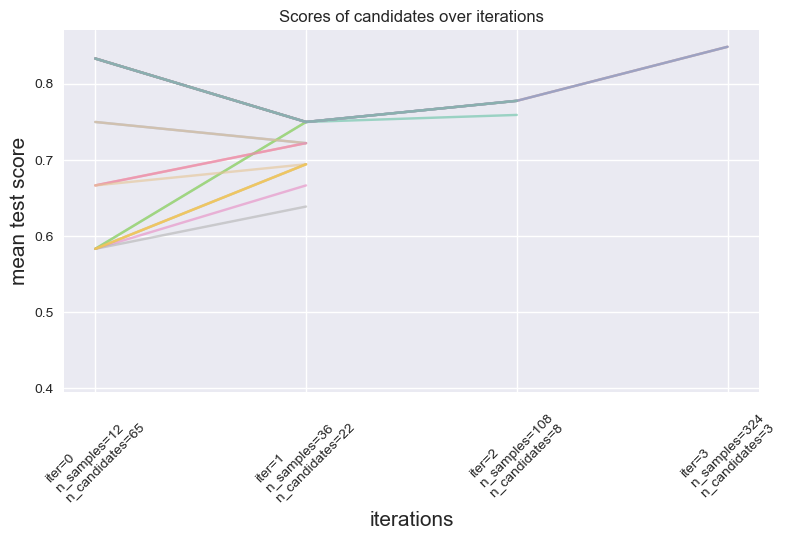

In [47]:
results = pd.DataFrame(search_results_clf.cv_results_)
results['params_str'] = results.params.apply(str)
results.drop_duplicates(subset=('params_str', 'iter'), inplace=True)
accuracy_scores = results.pivot(
    index='iter', columns='params_str', values='mean_test_score'
)

ax = accuracy_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={search_results_clf.n_resources_[i]}" + \
    f"\nn_candidates={search_results_clf.n_candidates_[i]}"
    for i in range(search_results_clf.n_iterations_)
]

ax.set_xticks(range(search_results_clf.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

# Прогноз на отложенные наблюдения

In [40]:
X_pred = DF_predict_num.drop(['HeartDisease'], axis=1)
y_hat = search_results_clf.best_estimator_.predict(X_pred)
print(classification_report(DF_predict_num['HeartDisease'], y_hat))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81        58
           1       0.87      0.85      0.86        80

    accuracy                           0.84       138
   macro avg       0.84      0.84      0.84       138
weighted avg       0.84      0.84      0.84       138

